In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
import yfinance as yf
import datetime
import statsmodels.api as sm
import csv
import calendar

# Benchmark Processing

Benchmarks are confirmed to be Li2CO3 and LiOH from Wind Database

In [2]:
def wind_process(df):
    df.set_index('Date', inplace = True)
    df.rename(columns = {df.columns[0]: 'Price'}, inplace = True)
    df.index = pd.to_datetime(df.index)
    df['Price'].replace(0, np.NaN, inplace = True)
    return df

# def str_to_num(s):
#     s = str(s).replace(',', '')
#     return float(s)

# def investing_process(df): # investing.com processing
#     df['Date'] = pd.to_datetime(df['Date'], format = '%m/%d/%Y')
#     df.set_index('Date', inplace = True)
#     df.sort_index(ascending=True, inplace = True)
#     df['Price'] = df['Price'].apply(str_to_num)
#     df['Price'].replace(0, np.NaN, inplace = True)
#     return df

def get_weekly(df, d): # d: 0-4 for Mon-Fri
    w = df.copy()
    w.rename(columns = {w.columns[0]: 'Price'}, inplace = True)

    # Select one weekday
    w = w[w.index.dayofweek == d]

    w['Prior_Date'] = w.index - datetime.timedelta(days=7) # Get date one week ago
    w['Prior_Price'] = w['Prior_Date'].apply(lambda i: w.loc[i,'Price'] if i in w.index else np.NaN) # Get price one week ago
    w['Weekly_Return'] = np.log(w.Price) - np.log(w.Prior_Price) # Weekly return
    w['Weekly_Return'].replace([np.inf, -np.inf], np.NaN, inplace = True)

    w = w.drop(columns = ['Prior_Date','Prior_Price'])
    return w

def zeros(df, freq): # Get daily return and zeros, freq = 'M' for monthly end zeros, 'A' for yearly end zeros

    df.rename(columns = {df.columns[0]: 'Price'}, inplace = True)
    df['Daily_Return'] = np.log(df['Price']).diff() # Daily return
    df['Daily_Return'].replace([np.inf, -np.inf], np.NaN, inplace = True)
    df['Zeros'] = (df['Daily_Return'] == 0).astype(int)

    if freq == 'M':
        z = df['Zeros'].resample(freq).sum() / 22
    else:
        z = df['Zeros'].resample(freq).sum() / 252
    # z = df['Zeros'].resample(freq).sum() / df[freq].resample('M').size()
    return z.to_frame()

# def get_return(df): # Get weekly return for each day

#     # Rename 'Adj Close' to 'Price'
#     df.rename(columns = {df.columns[0]: 'Price'}, inplace = True)

#     # Weekly return calculate Mon-Mon, Tue-Tue, Wed-Wed, Thu-Thu, Fri-Fri return
#     # SELECTION BY dayofweek IS NEEDED WHEN ANALYZIING Weekly_Return
#     df['Prior_Date'] = df.index - datetime.timedelta(days=7) # Get date one week ago
#     df['Prior_Price'] = df['Prior_Date'].apply(lambda i: df.loc[i,'Price'] if i in df.index else np.NaN) # Get price one week ago
#     df['Weekly_Return'] = np.log(df.Price) - np.log(df.Prior_Price) # Weekly return
#     df['Weekly_Return'].replace([np.inf, -np.inf], np.NaN, inplace = True)
    
#     # Get Daily Return
#     df['Daily_Return'] = np.log(df['Price']).diff() # Daily return
#     df['Daily_Return'].replace([np.inf, -np.inf], np.NaN, inplace = True)
#     df['Zeros'] = (df['Daily_Return'] == 0).astype(int)

#     df = df.drop(columns = ['Prior_Date','Prior_Price','Daily_Return'])

# def get_daily(df): # Get Daily Return
#     df.rename(columns = {df.columns[0]: 'Price'}, inplace = True)
#     df['Daily_Return'] = np.log(df['Price']).diff() # Daily return
#     df['Daily_Return'].replace([np.inf, -np.inf], np.NaN, inplace = True)

y_all = {
    'li2co3': wind_process(pd.read_csv('./Data/Lithium Carbonate (wind database).csv')), # Wind Lithium Carbonate Price
    'lioh': wind_process(pd.read_csv('./Data/Lithium Hydroxide (wind database).csv')), # Wind Lithium Hydroxide Price
    # 'ltcb': investing_process(pd.read_csv('./Data/99C-LTCB.csv', usecols=[0,1])), # Investing.com Lithium Carbonate (Li2CO3) 99% Min China Spot
    # 'ltmt': investing_process(pd.read_csv('./Data/99MIN-LTMT.csv', usecols=[0,1])) # Investing.com 99% Min China Lithium Metal Spot
}

## Benchmark Zeros
### Monthly Zeros
Around 2014, a lot of days are missing. It has data one or twice a week. Ratios exceed 1 because the denominator is set as 22, one month may include more than 22 days. And in 2017, clusters of data missing.

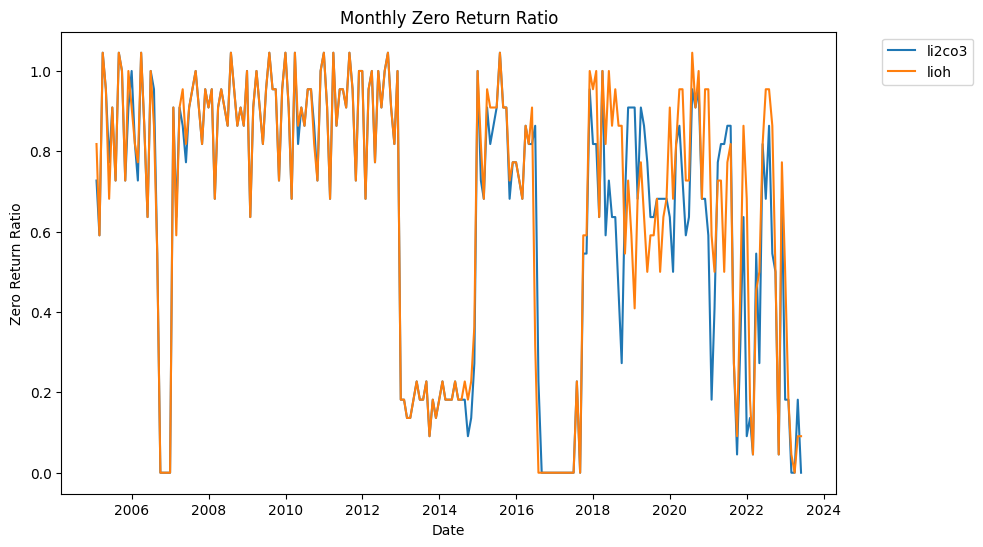

In [3]:
y_zeros_m = {df: zeros(y_all[df], 'M') for df in y_all}

fig_zeros_m = plt.figure(figsize = (10,6))
for df in y_zeros_m:
    plt.plot(y_zeros_m[df], label = df)

plt.title('Monthly Zero Return Ratio')
plt.xlabel('Date')
plt.ylabel('Zero Return Ratio')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

### Yearly Zeros Table

In [4]:
y_zeros_y = {df: zeros(y_all[df],'A') for df in y_all}

zeros_table = pd.DataFrame(index = y_zeros_y['li2co3'].index)
for df in y_zeros_y:
    zeros_table = pd.merge(zeros_table, y_zeros_y[df].loc[:,'Zeros'], how='left', left_index=True, right_index=True, suffixes=(None,f'_{df}'))
zeros_table.rename(columns = {'Zeros':'Zeros_li2co3'}, inplace=True)
display(zeros_table)

,Zeros_li2co3,Zeros_lioh
Date,,
2005-12-31,0.908730,0.908730
2006-12-31,0.575397,0.571429
2007-12-31,0.920635,0.928571
2008-12-31,0.952381,0.952381
2009-12-31,0.952381,0.952381
2010-12-31,0.940476,0.940476
2011-12-31,0.964286,0.964286
2012-12-31,0.896825,0.896825
2013-12-31,0.178571,0.178571


## Benchmark Weekly Return

In [5]:
for i in range(5):
    for df in y_all:
        globals()[f'y_{i}'] = {df: get_weekly(y_all[df],i) for df in y_all}

# Time Series Task 1

## Import Data from yahoo finance
See Upstream_companies.csv for stock details.

In [6]:
upstream = pd.read_csv('./Data/Upstream_companies.csv').iloc[:,1:] # first col is index
up_list = upstream['Stock'].tolist()
up_price = {s: yf.download(s, end='2023-05-22', interval='1d')['Adj Close'].to_frame() for s in up_list}
# up_price = {s: yf.download(s, start='2017-09-08', end='2023-05-22', interval='1d')['Adj Close'].to_frame() for s in upstream}

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [7]:
for i in range(5):
    globals()['p_' + str(i)] = {df: get_weekly(up_price[df],i) for df in up_price}

def week_mean_std(i): # i: 0-4 for weekdays
    upstream[f'{calendar.day_abbr[i]}_Mean'] = upstream['Stock'].apply(lambda m: globals()[f'p_{i}'][m]['Weekly_Return'].mean())
    upstream[f'{calendar.day_abbr[i]}_Std'] = upstream['Stock'].apply(lambda m: globals()[f'p_{i}'][m]['Weekly_Return'].std())

for i in range(5):
    week_mean_std(i)

upstream

,Name,Stock,Exchange,Currency,Time Zone,Market Cap,Mon_Mean,Mon_Std,Tue_Mean,Tue_Std,Wed_Mean,Wed_Std,Thu_Mean,Thu_Std,Fri_Mean,Fri_Std
0,Jiangxi Special Electric Motor,002176.SZ,SHZ,CNY,CST,19213.275136,0.002553,0.086695,0.002604,0.083385,0.000908,0.082072,0.001832,0.081787,0.001626,0.083428
1,Ganfeng Lithium,002460.SZ,SHZ,CNY,CST,110657.830912,0.003179,0.080333,0.003463,0.080160,0.002892,0.076810,0.003320,0.076494,0.003450,0.073864
2,Tianqi Lithium,002466.SZ,SHZ,CNY,CST,95878.569984,0.002161,0.084140,0.002181,0.087295,0.001644,0.084321,0.003232,0.083034,0.003027,0.080391
3,Sichuan Yahua Group,002497.SZ,SHZ,CNY,CST,20699.975680,0.003092,0.073724,0.001984,0.075126,0.000781,0.073715,0.000815,0.073283,0.001077,0.071644
4,Allkem Limited,AKE.AX,ASX,AUD,AEST,9067.496448,0.006989,0.096254,0.004466,0.090993,0.005326,0.092006,0.004509,0.087157,0.004759,0.092303
5,Albemarle,ALB,NYQ,USD,EDT,22788.997120,0.002505,0.052509,0.002585,0.048654,0.002586,0.048083,0.002374,0.051374,0.002053,0.049545
6,Atlantic Lithium,ALL.L,LSE,GBp,BST,125.040856,0.002957,0.121701,0.002492,0.108047,0.003155,0.108891,0.002414,0.108857,0.002963,0.110329
7,American Lithium,AMLI,NCM,USD,EDT,306.956640,-0.001867,0.164701,0.002075,0.157571,-0.001007,0.153584,0.002900,0.157093,-0.000520,0.155491
8,Critical Elements Lithium Corporation,CRE.V,VAN,CAD,EDT,363.700928,0.001170,0.136252,0.002816,0.123515,0.002228,0.124968,0.001105,0.113953,0.001732,0.123298
9,Eramet SA,ERA.PA,PAR,EUR,CEST,2222.308864,0.000180,0.072783,0.000474,0.072119,0.000786,0.070787,0.000156,0.071814,-0.000148,0.072158


## First Order Autocorrelation

In [8]:
def plot_autocorr(i): # i: 0-4 for p_0, p_1, p_2, p_3, p_4
    for df in globals()[f'p_{i}']:
        fig, ax = plt.subplots(1,2,figsize=(10,5))
        plot_acf(globals()[f'p_{i}'][df]['Weekly_Return'].dropna(), lags=40, alpha = 0.05, title = f'{df}_{calendar.day_abbr[i]} Autocorrelation', ax=ax[0])
        plot_pacf(globals()[f'p_{i}'][df]['Weekly_Return'].dropna(), lags=40, alpha = 0.05, method = 'ols', title = f'{df}_{calendar.day_abbr[i]} Partial Autocorrelation', ax=ax[1])
        plt.show()

# for i in range(5):
#    plot_autocorr(i)


## Zeros

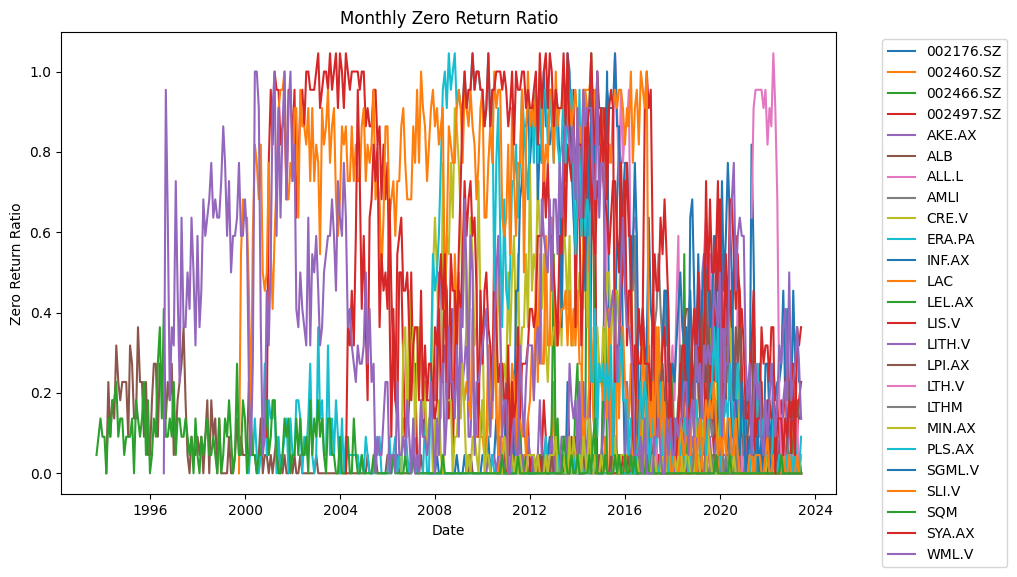

In [9]:
up_zeros = {df: zeros(up_price[df],'M') for df in up_price}

fig_zeros_m = plt.figure(figsize = (10,6))
for df in up_zeros:
    plt.plot(up_zeros[df], label = df)

plt.title('Monthly Zero Return Ratio')
plt.xlabel('Date')
plt.ylabel('Zero Return Ratio')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

# Time Series Task 2